#### Notebook options

In [1]:
%load_ext autoreload
# Set extension to reload modules every time before executing code
%autoreload 2  #0 to turn of reloading

In [2]:
### Print not only the last line in a cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
### Don't autoclose brackets
from notebook.services.config import ConfigManager
c = ConfigManager()
c.update('notebook', {"CodeCell": {"cm_config": {"autoCloseBrackets": False}}})

{'Cell': {'cm_config': {'lineNumbers': True}},
 'CodeCell': {'cm_config': {'autoCloseBrackets': False}},
 'load_extensions': {'jupyter-js-widgets/extension': True}}

#### Imports

In [4]:
# import bokeh
# import time
# import copy
# import scipy.stats as ss

# from coffea import hist, processor, nanoevents, util
# from coffea.nanoevents.methods import candidate
# from coffea.nanoevents import NanoAODSchema, BaseSchema

# import awkward as ak
# import numpy as np
# import glob as glob
# import itertools
# import pandas as pd
# from numpy.random import RandomState

# from dask.distributed import Client
# import inspect
# import matplotlib.pyplot as plt
# import matplotlib as mpl

# from pltStyle import pltStyle
# import os
# # %matplotlib notebook 
# # %matplotlib notebook 

In [5]:
# import sys
# sys.path.insert(0,'/afs/cern.ch/user/a/anpotreb/top/JERC/coffea/')
# sys.path

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
from scipy.optimize import curve_fit
import matplotlib as mpl

In [7]:
from pltStyle import pltStyle
pltStyle(style='paper')
plt.rcParams['figure.subplot.left'] = 0.162
plt.rcParams['figure.dpi'] = 150

In [8]:
tag = '_L5'                 ### L5 or L23, but L23 not supported since ages

### name of the specific run:
# add_tag = '_LHEflav1_TTBAR-Summer16-cFlip' #'_LHEflav1_TTBAR-JME' #'_LHEflav1_TTBAR-Summer16-cFlip' #'_Herwig-TTBAR' # '_TTBAR' #'_QCD' # '_testing_19UL18' # '' #fine_etaBins
# add_tag='_fine_etaBins'+add_tag
add_tag = '_QCD-JME'

tag_full = tag+add_tag

In [9]:
def read_data(name, samp):
    df_csv = pd.read_csv('out_txt/EtaBinsvsPtBins'+name+'_'+samp+tag_full+'.csv').set_index('etaBins')
    data = df_csv.to_numpy().transpose()
    return data

### Fitting the inverse median responses

In [10]:
df = pd.read_csv('out_txt/EtaBinsvsPtBins'+"Mean"+"_b"+tag_full+'.csv').set_index('etaBins')

In [11]:
etabins = np.append(df.index.to_numpy(), 5.191)
ptbins = np.append(df.columns.to_numpy(float), 10000)
ptbins_c = (ptbins[:-1]+ptbins[1:])/2

In [12]:
# samp = '_b'
# etabin = 1

# mean = read_data("Mean", samp)
# meanvar = read_data("MeanVar", samp)

In [13]:
# means = mean[:, etabin]
# means2fit = means[means!=0.0]
# ptbins2fit = ptbins[:-1][means!=0.0]
# meanvar2fit = np.abs(meanvar[means!=0.0,etabin])

# xvals = np.linspace(ptbins2fit.min() - (0.5), ptbins2fit.max()+(ptbins2fit[-1]-ptbins2fit[-11]),1000)

In [14]:
def ptscale2int2(x, ptmin, ptmax):
    z = np.log10(x)
    return ((z-ptmin)-(ptmax-z))/(ptmax-ptmin);

In [15]:
def ptscale2int(x, ptbins):
    ptmax = max(np.log10(ptbins))
    ptmin = min(np.log10(ptbins))
    z = np.log10(x)
    return ((z-ptmin)-(ptmax-z))/(ptmax-ptmin);

# def int2pt(z, ptbins):
#     Mi = np.min(np.log10(ptbins))
#     Ma = np.max(np.log10(ptbins))
#     pts = z/2*(Ma-Mi) + (Ma + Mi)/2
#     return 10**pts

In [16]:
def sum_cheb_tmp(x, ptbins, *p):
    c0, c1, c2, c3, c4 = p
    xs = ptscale2int(x, ptbins)
    res = (c0 * sp.special.eval_chebyt(0, xs) +
           c1 * sp.special.eval_chebyt(1, xs) + 
           c2 * sp.special.eval_chebyt(2, xs) + 
           c3 * sp.special.eval_chebyt(3, xs) + 
           c4 * sp.special.eval_chebyt(4, xs) )
    return res

def sum_cheb5_tmp(x, ptbins, *p):
    c0, c1, c2, c3, c4, c5 = p
    xs = ptscale2int(x, ptbins)
    res = (c0 * sp.special.eval_chebyt(0, xs) +
           c1 * sp.special.eval_chebyt(1, xs) + 
           c2 * sp.special.eval_chebyt(2, xs) + 
           c3 * sp.special.eval_chebyt(3, xs) + 
           c4 * sp.special.eval_chebyt(4, xs) + 
           c5 * sp.special.eval_chebyt(5, xs) )
    return res

def sum_cheb3_tmp(x, ptbins, *p):
    c0, c1, c2, c3 = p
    xs = ptscale2int(x, ptbins)
    res = (c0 * sp.special.eval_chebyt(0, xs) +
           c1 * sp.special.eval_chebyt(1, xs) + 
           c2 * sp.special.eval_chebyt(2, xs) + 
           c3 * sp.special.eval_chebyt(3, xs) )
    return res

def sum_cheb2_tmp(x, ptbins, *p):
    c0, c1, c2 = p
    xs = ptscale2int(x, ptbins)
    res = (c0 * sp.special.eval_chebyt(0, xs) +
           c1 * sp.special.eval_chebyt(1, xs) + 
           c2 * sp.special.eval_chebyt(2, xs) )
    return res

In [17]:
def poly4(x, *p):
    c0, c1, c2, c3, c4 = p
    xs = np.log10(x)
    res = c0+c1*xs+c2*xs**2+c3*xs**3+c4*xs**4
    return res

# def sum_cheb5_tmp(x, ptbins, *p):
#     c0, c1, c2, c3, c4, c5 = p
#     xs = ptscale2int(x, ptbins)
#     res = (c0 * sp.special.eval_chebyt(0, xs) +
#            c1 * sp.special.eval_chebyt(1, xs) + 
#            c2 * sp.special.eval_chebyt(2, xs) + 
#            c3 * sp.special.eval_chebyt(3, xs) + 
#            c4 * sp.special.eval_chebyt(4, xs) + 
#            c5 * sp.special.eval_chebyt(5, xs) )
#     return res

# def sum_cheb3_tmp(x, ptbins, *p):
#     c0, c1, c2, c3 = p
#     xs = ptscale2int(x, ptbins)
#     res = (c0 * sp.special.eval_chebyt(0, xs) +
#            c1 * sp.special.eval_chebyt(1, xs) + 
#            c2 * sp.special.eval_chebyt(2, xs) + 
#            c3 * sp.special.eval_chebyt(3, xs) )
#     return res

# def sum_cheb2_tmp(x, ptbins, *p):
#     c0, c1, c2 = p
#     xs = ptscale2int(x, ptbins)
#     res = (c0 * sp.special.eval_chebyt(0, xs) +
#            c1 * sp.special.eval_chebyt(1, xs) + 
#            c2 * sp.special.eval_chebyt(2, xs) )
#     return res

In [18]:
def response_fnc_raw(x, p0, p1, p2, p3, p4, p5):
    response_fnc(x, *[p0, p1, p2, p3, p4, p5])

In [19]:
def response_fnc(x, *p):
    p0, p1, p2, p3, p4, p5 = p
    logx = np.log10(x)
    return p0+(p1/((logx**2)+p2)) + (p3*np.exp(-p4*((logx-p5)*(logx-p5))))

def two_gaus_fnc(x, *p):
    p0, p1, p2, p3, p4, p5, p6, p7, p8 = p
    return (  p0
            + (p1/((np.log10(x)**2)+p2))
            + (p3*np.exp(-p4*((np.log10(x)-p5)*(np.log10(x)-p5))))
            + (p6*np.exp(-p7*((np.log10(x)-p8)*(np.log10(x)-p8))))
           )
#     return A*np.exp(-(x-mu)**2/(2.*sigma**2))

In [20]:
#### initial values borrowed from Winter14 data
#### https://github.com/cms-jet/JECDatabase/blob/master/textFiles/Winter14_V8_MC/Winter14_V8_MC_L5Flavor_AK5Calo.txt/
#### used for fit `response_fnc`
init_vals_2014 = {
    'b':
    [[0.540002, 13.8495, 17.8549, -0.215711, 0.576285, 1.42258],
    [0.73119, 7.52866, 17.3681, -0.078402, 1.21665, 1.69878],
    [0.999952, 0.0322738, -1.05606, -19.6994, 0.720321, -1.58314],
    [0.135913, 7.92441, 3.85698, -0.804604, 1.11911, 0.732041]],
    'c' :
    [[ 0.940259, 0.705481, 0.23917, -0.826926, 0.311473, -0.514041],
    [0.982083, 0.238007, 4.35924, -0.0314618, 5.91028, 1.67749],
    [0.733505, 7.26794, 12.2028, -0.756302, 0.0895257, -1.96324],
    [0.932305, 1.15954, 17.1731, -0.471313, 2.58424, 0.254917]],
    'g' :
    [[0.877892, 3.10194, 1.16568, -677.876, 0.0325026, -12.9485],
    [0.983775, 0.247943, 1.55373, -0.0254802, 3.35748, 1.71263],
    [-0.972548, 38.8683, 2.47151, -44.0233, 0.0901665, -3.15495],
    [1.0655, -0.0680325, -0.509038, -8.59434e+06, 42.6162, 0.357177]],
    'd':
    [[1.28488, -46.3648, 151.749, -0.0108461, 15.4256, 1.63377],
    [ 1.50931, -118.71, 224.19, -0.0196468, 4.62655, 1.51581],
    [0.692016, 8.26488, 11.1655, -0.802769, 0.116182, -1.16094],
    [1.01244, -0.0926519, -0.12138, -3.69494e+07, 7.15634, -0.625288]],  
    'u':
    [[1.28488, -46.3648, 151.749, -0.0108461, 15.4256, 1.63377],
    [ 1.50931, -118.71, 224.19, -0.0196468, 4.62655, 1.51581],
    [0.692016, 8.26488, 11.1655, -0.802769, 0.116182, -1.16094],
    [1.01244, -0.0926519, -0.12138, -3.69494e+07, 7.15634, -0.625288]],  
    's':
    [[1.28488, -46.3648, 151.749, -0.0108461, 15.4256, 1.63377],
    [ 1.50931, -118.71, 224.19, -0.0196468, 4.62655, 1.51581],
    [0.692016, 8.26488, 11.1655, -0.802769, 0.116182, -1.16094],
    [1.01244, -0.0926519, -0.12138, -3.69494e+07, 7.15634, -0.625288]],
    'all':
    [[0.540002, 13.8495, 17.8549, -0.215711, 0.576285, 1.42258],
    [0.73119, 7.52866, 17.3681, -0.078402, 1.21665, 1.69878],
    [0.999952, 0.0322738, -1.05606, -19.6994, 0.720321, -1.58314],
    [0.135913, 7.92441, 3.85698, -0.804604, 1.11911, 0.732041]],
    
}

Initial values for the two gaussian fit

In [21]:
#         fabscor->SetRange(3,2000);
init_two_gaus = [3,0,1,2,0,1,2,3,4]

#         fabscor->SetParameter(0,flog->GetParameter(3));
#         fabscor->SetParameter(1,flog->GetParameter(0));
#         fabscor->SetParameter(2,flog->GetParameter(1));
#         fabscor->SetParameter(3,flog->GetParameter(2));
#         fabscor->SetParLimits(1,0,5);
#         fabscor->SetParLimits(2,-20,20);
#         fabscor->SetParLimits(3,0,5);
#         fabscor->SetParameter(4,fgaus->GetParameter(0));
#         fabscor->SetParameter(5,fgaus->GetParameter(1));
#         fabscor->SetParameter(6,fgaus->GetParameter(2));
#         fabscor->SetParameter(7,fgaus->GetParameter(3));
#         fabscor->SetParameter(8,fgaus->GetParameter(4));
#         fabscor->SetParameter(9,fgaus->GetParameter(5));
#         fabscor->SetParLimits(6,0.1,100);
#         fabscor->SetParLimits(7,-100,0);
#         fabscor->SetParLimits(8,0,100);

Better starting fit values I found

In [22]:
init_vals_2014['b'][0] = [ 9.81014871e-01, -6.46744813e-03, -1.05658840e+00,  5.35445486e+03, 2.99200015e+01,  1.21399356e+02]
init_vals_2014['b'][3] = [ 9.81014871e-01, -6.46744813e-03, -1.05658840e+00,  5.35445486e+03, 2.99200015e+01,  1.21399356e+02]

In [23]:
def sum_cheb_tmp(x, ptbins, *p):
    c0, c1, c2, c3, c4 = p
    xs = ptscale2int(x, ptbins)
    res = (c0 * sp.special.eval_chebyt(0, xs) +
           c1 * sp.special.eval_chebyt(1, xs) + 
           c2 * sp.special.eval_chebyt(2, xs) + 
           c3 * sp.special.eval_chebyt(3, xs) + 
           c4 * sp.special.eval_chebyt(4, xs) )
    return res

In [24]:
# mean = read_data("Median", samp)[:,etabin]
# read_data("Mean", samp)[:,etabin]
# mean

In [25]:
# validpt_mask = np.isnan(mean)


### Fitting the mean responses

In [26]:
my_mapping = {"all": "aJ",
              "b": "bT",
              "c": "cT",
              "s": "sT",
              "g": "gT",
              "u": "uT",
              "d": "dT",
              "ud": "udT",
              "udc": "qT",}

In [27]:
# np.sqrt(meanvar2fit)/means2fit
# min_rel_uncert = 0.001

# meanstd = np.sqrt(meanvar2fit)
# where_limit_std = meanstd>min_rel_uncert
# meanstd[where_limit_std] = min_rel_uncert*means2fit[where_limit_std]

### When do you actually use Chebyshev:
https://stats.stackexchange.com/questions/434936/polynomial-chebyshev-regression-versus-multi-linear-regression?newreg=cc4a43fd464948cca9089469c2f49b39
Normal polynomes should give just as good results

In [28]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [29]:
# interact(response_fnc_raw, x=2, p0=10);

In [30]:
# all_subsamples = ['b', 'c', 'u', 'd', 'g', 's', 'all']

# import ipywidgets as widgets

# sub = widgets.Dropdown(
#     options=all_subsamples,
#     value='b',
#     description='Subsample:',
#     disabled=False,
# )

# etabin = widgets.Dropdown(
#     options=[0,1,2,3,4],
#     value=0,
#     description='Subsample:',
#     disabled=False,
# )

# print(init_vals_2014[sub.value][etabin.value])

# p0 = widgets.FloatSlider(value=7.5, min=0, max=10.0, step=0.1,
#                          description='p0', continuous_update=True, 
#                         )
# p1 = widgets.FloatSlider(value=13.8495, min=0, max=20.0, step=0.1, description='p2', continuous_update=True,
#                         )

# p2 = widgets.FloatSlider(
#     value=17.8549,
#     min=0,
#     max=20.0,
#     step=0.1,
#     description='p2',
#     continuous_update=True,
# )

# p3 = widgets.FloatSlider(
#     value=-0.215711,
#     min=-10.0,
#     max=10.0,
#     step=0.1,
#     description='p3',
#     continuous_update=True,
# )

# p4 = widgets.FloatSlider(
#     value=0.576285,
#     min=0,
#     max=10.0,
#     step=0.1,
#     description='p4',
#     continuous_update=True,
# )

# p5 = widgets.FloatSlider(
#     value=1.42258,
#     min=0,
#     max=10.0,
#     step=0.1,
#     description='p5',
#     continuous_update=True,
# )



# display(sub, etabin, p0, p1, p2, p3, p4, p5)

# # [0.540002, 13.8495, 17.8549, -0.215711, 0.576285, 1.42258]

In [31]:
init_vals_2014['b']

[[0.981014871, -0.00646744813, -1.0565884, 5354.45486, 29.9200015, 121.399356],
 [0.73119, 7.52866, 17.3681, -0.078402, 1.21665, 1.69878],
 [0.999952, 0.0322738, -1.05606, -19.6994, 0.720321, -1.58314],
 [0.981014871, -0.00646744813, -1.0565884, 5354.45486, 29.9200015, 121.399356]]

In [32]:
# a = widgets.IntSlider(description="Delayed", continuous_update=False)
# b = widgets.IntText(description="Delayed", continuous_update=False)
# c = widgets.IntSlider(description="Continuous", continuous_update=True)
# d = widgets.IntText(description="Continuous", continuous_update=True)

# widgets.link((a, 'value'), (b, 'value'))
# widgets.link((a, 'value'), (c, 'value'))
# widgets.link((a, 'value'), (d, 'value'))
# widgets.VBox([a,b,c,d])

In [33]:
# the_interaction = interactive(fit_corrections_for_interact, samp=all_subsamples, etabin=(0,3,1), p0=(-2,2,0.01), p1=(-200,200,0.1),
#                p2=(-10,300,0.1), p3=(-50,10,0.5), p4=(-1,10,0.1), p5=(-3,3,0.1), plot_initial_val=True ) 

# output2 = widgets.Output()

# for widg in the_interaction.children[:-1]:
# #     if "p" in widg.description:
#     widg.continuous_update = False

# samp_inter = the_interaction.children[0]
# eta_inter = the_interaction.children[1]
# pt_inter = the_interaction.children[2:8]
# # pt_inter = init_vals_2014[samp_inter.value][eta_inter.value]
# for ptii, init_val in zip(pt_inter, init_vals_2014[samp_inter.value][eta_inter.value]):
#     ptii.value = init_val
    
# def redefine_initial_vals_eta(change):
#     with output2:
# #         if change['new'] == 0:
# #             return
#         print(change['new'])
#         for ptii, init_val in zip(pt_inter, init_vals_2014[samp_inter.value][change['new']['value']]):
# #         [pt_inter[0].value, pt_inter[1].value] = init_vals_2014[samp_inter.value][change['new']['value']][:1]
#             ptii.value = init_val
            
# def redefine_initial_vals_sample(change):
#     with output2:
# #         if change['new'] == 0:
# #             return
#         print(change['new'])
#         for ptii, init_val in zip(pt_inter, init_vals_2014[change['new']['value']][eta_inter.value]):
#             ptii.value = init_val
# #         pt_inter[0].value = init_vals_2014[samp_inter.value][change['new']['value']][0]
# #     for ptii, init_val in zip(pt_inter, init_vals_2014[samp_inter.value][eta_inter.value]):
# #     ptii.value = init_val
    
# eta_inter.observe(redefine_initial_vals_eta)
    
# display(the_interaction)

In [34]:
# debug

In [35]:
# fit_corrections('b', 1)

In [80]:
# ptbins

array([   15.,    17.,    20.,    23.,    27.,    30.,    35.,    40.,
          45.,    57.,    72.,    90.,   120.,   150.,   200.,   300.,
         400.,   550.,   750.,  1000.,  1500.,  2000.,  2500.,  3000.,
        3500.,  4000.,  4500.,  5000., 10000.])

In [44]:
ptbins_c[len(ptbins_c)-9]
ptbins_c[len(ptbins_c)-8]
ptbins[len(ptbins)-9]
ptbins[len(ptbins)-8]

1250.0

1750.0

1500.0

2000.0

In [76]:
def fit_corrections(samp, etabin, init_vals_Winter14=np.array([1,1,1,1,1,1]), plot_initial_val=False):
    print('Fitting subsample: ', samp, 'Eta bin = : ', etabin)
    mean = (1/read_data("Median", samp)[:,etabin])*closure[:,etabin]
    meanvar = mean**2*read_data("MedianStd", samp)[:,etabin]**2

    ptmin_idx = np.searchsorted(ptbins_c, 20, side='left')-1
    ptmax_idx = np.searchsorted(ptbins_c, 1700, side='right')
    mean_range = range(ptmin_idx, ptmax_idx)


#         mean_range = mean_range_pt[:-1]

#         ptbins2fit = ptbins[mean_range_pt]
#         ptbins2fit = (ptbins2fit[:-1]+ptbins2fit[1:])/2
    means = mean[mean_range]
    ptbins2fit = ptbins_c[mean_range]
    validpt_mask = ~(np.isnan(means) | np.isinf(means) | (means==0))

    means2fit = means[validpt_mask]
    ptbins2fit = ptbins2fit[validpt_mask]
    meanvar2fit = np.abs(meanvar[mean_range][validpt_mask])

    ### Put the minimum limit on the relative uncertainty to min_rel_uncert
    meanstd = np.sqrt(meanvar2fit)
    where_limit_std = meanstd>min_rel_uncert
    meanstd[where_limit_std] = min_rel_uncert*means2fit[where_limit_std]

    fit_min_lim = min(ptbins[:-1][mean_range][validpt_mask])
    fit_max_lim = max(ptbins[1:][mean_range][validpt_mask])
#     assert False

    xplot = np.linspace(ptbins2fit.min() - (1), ptbins2fit.max()+50,1000) #-200 to plot the fitted curved outside of the points
    def sum_cheb(x, *p):
        return sum_cheb_tmp(x, ptbins2fit, *p)
    def sum_cheb5(x, *p):
        return sum_cheb5_tmp(x, ptbins2fit, *p)    
    def sum_cheb3(x, *p):
        return sum_cheb3_tmp(x, ptbins2fit, *p)  
    def sum_cheb2(x, *p):
        return sum_cheb2_tmp(x, ptbins2fit, *p)  

    print("init_vals_Winter14", init_vals_Winter14)
    try:
        p_resp, arr = curve_fit(response_fnc, ptbins2fit, means2fit, p0=init_vals_Winter14) #0.793149, 4.60568, 11.1553, -0.123262, 0.878497, 1.52041
        p_resp_err, arr = curve_fit(response_fnc, ptbins2fit, means2fit, p0=p_resp, sigma=meanstd)
    except(RuntimeError):
        print("Winter 14 fit failed")
        p_resp, p_resp_err = [[np.nan]*6]*2
    #      = np.nan*6

    try:
        p_resp2, arr = curve_fit(two_gaus_fnc, ptbins2fit, means2fit, p0=init_two_gaus) #0.793149, 4.60568, 11.1553, -0.123262, 0.878497, 1.52041
        p_resp_err2, arr = curve_fit(two_gaus_fnc, ptbins2fit, means2fit, p0=p_resp2, sigma=meanstd)
    except(RuntimeError):
        print("Two fits failed")
        p_resp2, p_resp_err2 = [[np.nan]*9]*2
    #      = np.nan*6


    # p_resp_err
    p_poly4_1, arr = curve_fit(poly4, ptbins2fit, means2fit, p0=[ 1, 1, 1, 1, 1])
    p_poly4, arr = curve_fit(poly4, ptbins2fit, means2fit, p0=p_poly4_1, sigma=meanstd)

    # p_resp_err
    p_cheb1, arr = curve_fit(sum_cheb, ptbins2fit, means2fit, p0=[ 1, 1, 1, 1, 1])
    p_cheb, arr = curve_fit(sum_cheb, ptbins2fit, means2fit, p0=p_cheb1, sigma=meanstd)
    p_cheb5_1, arr = curve_fit(sum_cheb5, ptbins2fit, means2fit, p0=[ 1, 1, 1, 1, 1, 1])
    p_cheb5, arr = curve_fit(sum_cheb5, ptbins2fit, means2fit, p0=p_cheb5_1, sigma=meanstd)
    p_cheb3_1, arr = curve_fit(sum_cheb3, ptbins2fit, means2fit, p0=[ 1, 1, 1, 1])
    p_cheb3, arr = curve_fit(sum_cheb3, ptbins2fit, means2fit, p0=p_cheb3_1, sigma=meanstd)
    p_cheb2_1, arr = curve_fit(sum_cheb2, ptbins2fit, means2fit, p0=[ 1, 1, 1])
    p_cheb2, arr = curve_fit(sum_cheb2, ptbins2fit, means2fit, p0=p_cheb2_1, sigma=meanstd)

    expr = 0
    for ii in range(len(p_cheb3)):
        expr+=p_cheb3[ii]* chebyshevt(ii,x)
    poly_coefs = np.array(sympy.Poly(expr).all_coeffs(), dtype=float)
#         len(poly_coefs)
    fit_res_new = np.concatenate([[etabins[etabin], etabins[etabin+1],
                               len(p_poly4), 
                               fit_min_lim, fit_max_lim],
                              p_poly4 ])
#     fit_res = np.concatenate([fit_res,
#                               [etabins[etabin], etabins[etabin+1],
#                                len(p_cheb3), 
#                                fit_min_lim, fit_max_lim],
#                               p_cheb3 ])
    nofpars.append(len(p_cheb3))

    
    yvals_resp = response_fnc(xplot, *p_resp)
    yvals_resp_err = response_fnc(xplot, *p_resp_err)
    y_poly4 = poly4(xplot, *p_poly4)
    yvals = sum_cheb(xplot, *p_cheb)
#         yvals1 = sum_cheb(xplot, *p_cheb1)
    yvalsC5 = sum_cheb5(xplot, *p_cheb5)
#         yvalsC5_1 = sum_cheb5(xplot, *p_cheb5_1)
    yvalsC3 = sum_cheb3(xplot, *p_cheb3)
    yvalsC2 = sum_cheb2(xplot, *p_cheb2)

    chi2_poly4 = np.sum((poly4(ptbins2fit, *p_poly4) - means2fit)**2/meanstd**2)
    Ndof_poly4 = len(ptbins2fit) - 5

    chi2_resp = np.sum((response_fnc(ptbins2fit, *p_resp_err) - means2fit)**2/meanstd**2)
    chi2_C4 = np.sum((sum_cheb(ptbins2fit, *p_cheb) - means2fit)**2/meanstd**2)
    chi2_C5 = np.sum((sum_cheb5(ptbins2fit, *p_cheb5) - means2fit)**2/meanstd**2)
    chi2_C3 = np.sum((sum_cheb3(ptbins2fit, *p_cheb3) - means2fit)**2/meanstd**2)
    chi2_C2 = np.sum((sum_cheb2(ptbins2fit, *p_cheb2) - means2fit)**2/meanstd**2)
    Ndof_C4 = len(ptbins2fit) - 5
    Ndof_C5 = len(ptbins2fit) - 6
    Ndof_C3 = len(ptbins2fit) - 4
    Ndof_C2 = len(ptbins2fit) - 3
    Ndof_resp = len(ptbins2fit) - 6


    fig, ax = plt.subplots()

    plt.errorbar(ptbins2fit, means2fit, yerr=meanstd, marker='o',
                 linestyle="none", label=f'Data {etabins[etabin]}'+r'$<\eta<'+f'${etabins[etabin+1]}')

    eta_string = '_eta'+str(etabins[etabin])+'to'+str(etabins[etabin+1])
    eta_string = eta_string.replace('.','')
    if np.isnan(chi2_resp): 
        winter14_lab = 'Winter14 func, failed'
    else:
        winter14_lab= 'Original func, '+r'$\chi^2/N_{dof} = $'+r' {0:0.3g}/{1:0.0f}'.format(chi2_resp, Ndof_resp)
    
    ax.plot(xplot, yvals_resp_err, label=winter14_lab, linewidth=2.3);
    ax.plot(xplot, yvals_resp, label="Winer14, No uncertainty in fit", linewidth=1.5);
    ax.plot(xplot, y_poly4, label=r'Poly, n=4, '+r'$\chi^2/N_{dof} = $'+r' {0:0.3g}/{1:0.0f}'.format(chi2_poly4, Ndof_poly4),linewidth=2.7);
    ax.plot(xplot, yvals, label=r'Chebyshev, n=4, '+r'$\chi^2/N_{dof} = $'+r' {0:0.3g}/{1:0.0f}'.format(chi2_C4, Ndof_C4),linewidth=1.2);
#         ax.plot(xplot, yvalsC5, label=r'Chebyshev, n=5, '+r'$\chi^2/N_{dof} = $'+r' {0:0.3g}/{1:0.0f}'.format(chi2_C5, Ndof_C5),linewidth=1.8);
#     ax.plot(xplot, yvalsC3, label=r'Chebyshev, n=3, '+r'$\chi^2/N_{dof} = $'+r' {0:0.3g}/{1:0.0f}'.format(chi2_C3, Ndof_C3),linewidth=1.8);
#     ax.plot(xplot, yvalsC2, label=r'Chebyshev, n=2, '+r'$\chi^2/N_{dof} = $'+r' {0:0.3g}/{1:0.0f}'.format(chi2_C2, Ndof_C2),linewidth=1.8);

    if plot_initial_val:
        yvals_init = response_fnc(xplot, *init_vals_Winter14)
        ax.plot(xplot, yvals_init, label="Initial values for Winter14", linewidth=1.8);
        
    
    
#         yerr_norm = np.concatenate([np.sqrt(meanvar[start:,[k2, k4, k6, k8]]) ])
#         y_norm = np.concatenate([mean_p[start:,[k2, k4, k6, k8]]])
#     print("ynorm = ", y_norm)
#     print("yerr = ", yerr_norm)
    std = meanstd
    norm_pos = (std<0.1) &  (std != np.inf)
#     print("(yerr_norm+y_norm)[norm_pos]) = ", (yerr_norm+y_norm)[norm_pos])
    if not plot_initial_val:
        ax.set_ylim(np.min((means2fit-std)[norm_pos])-0.002 ,np.max((std+means2fit)[norm_pos])+0.002)

    ax.set_xlabel(r'$p_T$ (GeV)');
    ax.set_ylabel(r'correction (1/median)');
    ax.set_xscale('log')

    ax.set_xticks([])
    ax.set_xticks([20, 50, 100, 200, 500, 1000])
    ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

    # ax.set_ylim([0.8,1.1])
    ax.legend(prop={'size': 7})
#         if not test_run:
#             plt.savefig('fig/response_fit'+samp+eta_string+'.png', dpi=plt.rcParamsDefault['figure.dpi']);
#             plt.savefig('fig/response_fit'+samp+eta_string+'.pdf', dpi=plt.rcParamsDefault['figure.dpi']);
#         else:
#         plt.savefig('test/fig/response_fit'+samp+eta_string+'.png', dpi=plt.rcParamsDefault['figure.dpi']);
#         plt.savefig('test/fig/response_fit'+samp+eta_string+'.pdf', dpi=plt.rcParamsDefault['figure.dpi']);
    # fig.set_size_inches(6, 4, forward=True)
    plt.show();
    plt.close();
    
    return fit_res_new

In [77]:
def fit_corrections_for_interact(samp, etabin, p0=1, p1=1, p2=1, p3=1, p4=1, p5=1, plot_initial_val=False):
    fit_corrections(samp, etabin, init_vals_Winter14=np.array([p0, p1, p2, p3, p4, p5]), plot_initial_val=plot_initial_val)

In [78]:
# import sympy 
# from sympy import chebyshevt
# min_rel_uncert = 0.001
# x = sympy.symbols('x')
# closure = read_data("Median", 'all')
# fit_corrections('b', 1)
# init_vals_Winter14

Fitting subsample:  all Eta bin = :  0
init_vals_Winter14 [0.540002, 13.8495, 17.8549, -0.215711, 0.576285, 1.42258]


/tmp/anpotreb/ipykernel_32231/164847569.py:11: RuntimeWarning: overflow encountered in exp
  + (p6*np.exp(-p7*((np.log10(x)-p8)*(np.log10(x)-p8))))
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4/Thu/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


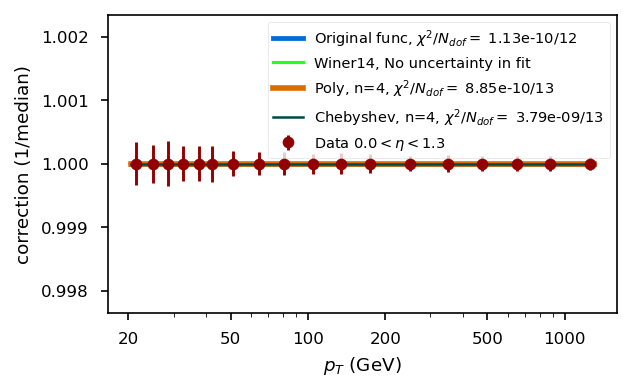

Fitting subsample:  all Eta bin = :  1
init_vals_Winter14 [0.73119, 7.52866, 17.3681, -0.078402, 1.21665, 1.69878]


/tmp/anpotreb/ipykernel_32231/4121896105.py:3: RuntimeWarning: invalid value encountered in multiply
  mean = (1/read_data("Median", samp)[:,etabin])*closure[:,etabin]
/tmp/anpotreb/ipykernel_32231/164847569.py:11: RuntimeWarning: overflow encountered in exp
  + (p6*np.exp(-p7*((np.log10(x)-p8)*(np.log10(x)-p8))))
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4/Thu/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


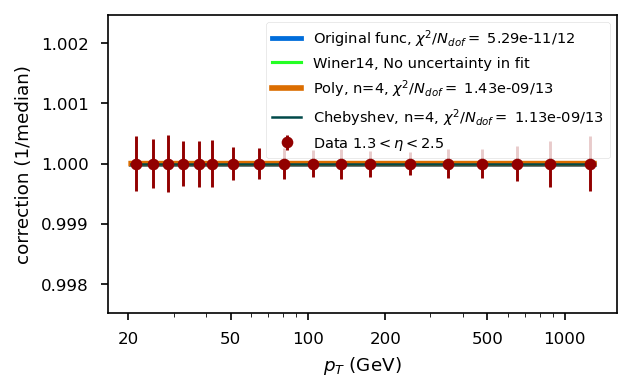

Fitting subsample:  all Eta bin = :  2
init_vals_Winter14 [0.999952, 0.0322738, -1.05606, -19.6994, 0.720321, -1.58314]


/tmp/anpotreb/ipykernel_32231/4121896105.py:3: RuntimeWarning: invalid value encountered in multiply
  mean = (1/read_data("Median", samp)[:,etabin])*closure[:,etabin]
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4/Thu/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


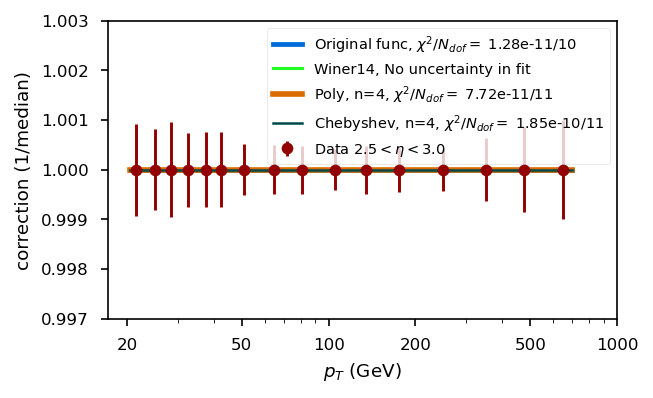

Fitting subsample:  all Eta bin = :  3
init_vals_Winter14 [0.135913, 7.92441, 3.85698, -0.804604, 1.11911, 0.732041]


/tmp/anpotreb/ipykernel_32231/4121896105.py:3: RuntimeWarning: invalid value encountered in multiply
  mean = (1/read_data("Median", samp)[:,etabin])*closure[:,etabin]
/tmp/anpotreb/ipykernel_32231/164847569.py:11: RuntimeWarning: overflow encountered in exp
  + (p6*np.exp(-p7*((np.log10(x)-p8)*(np.log10(x)-p8))))
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4/Thu/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


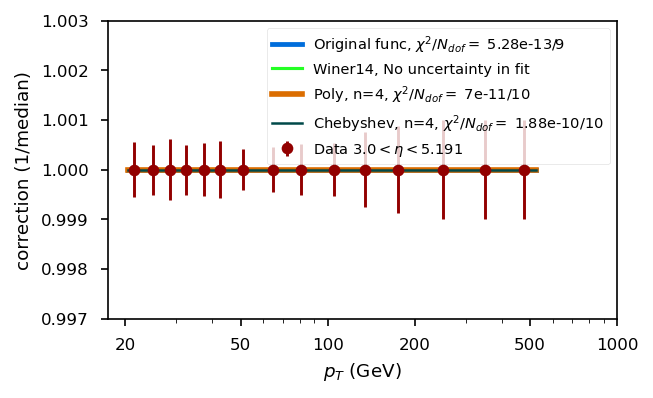

Fitting subsample:  b Eta bin = :  0
init_vals_Winter14 [0.981014871, -0.00646744813, -1.0565884, 5354.45486, 29.9200015, 121.399356]


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4/Thu/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


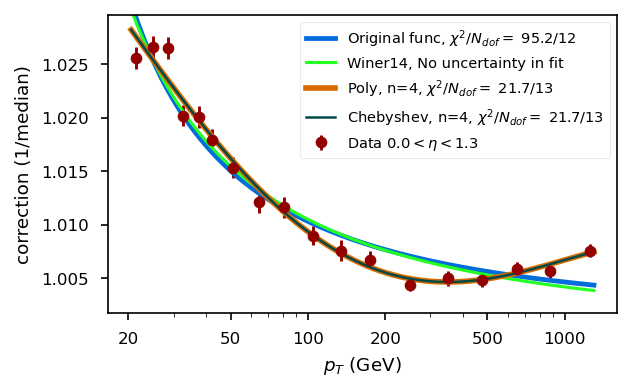

Fitting subsample:  b Eta bin = :  1
init_vals_Winter14 [0.73119, 7.52866, 17.3681, -0.078402, 1.21665, 1.69878]
Winter 14 fit failed
Two fits failed


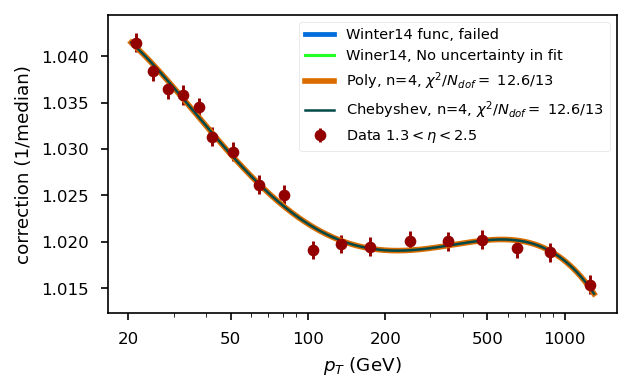

Fitting subsample:  b Eta bin = :  2
init_vals_Winter14 [0.999952, 0.0322738, -1.05606, -19.6994, 0.720321, -1.58314]
Two fits failed


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4/Thu/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/tmp/anpotreb/ipykernel_32231/164847569.py:10: RuntimeWarning: overflow encountered in exp
  + (p3*np.exp(-p4*((np.log10(x)-p5)*(np.log10(x)-p5))))


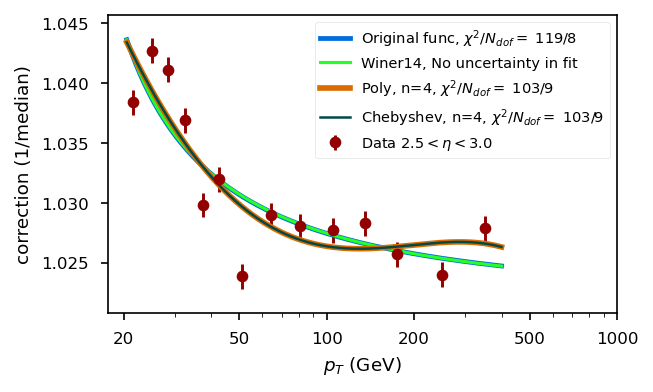

Fitting subsample:  b Eta bin = :  3
init_vals_Winter14 [0.981014871, -0.00646744813, -1.0565884, 5354.45486, 29.9200015, 121.399356]
Winter 14 fit failed


/tmp/anpotreb/ipykernel_32231/164847569.py:11: RuntimeWarning: overflow encountered in exp
  + (p6*np.exp(-p7*((np.log10(x)-p8)*(np.log10(x)-p8))))
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4/Thu/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


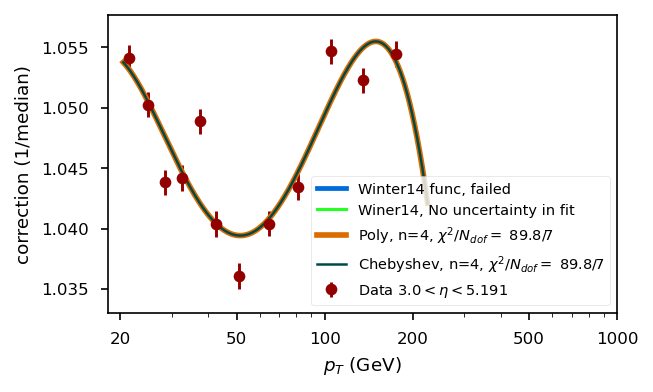

Fitting subsample:  c Eta bin = :  0
init_vals_Winter14 [0.940259, 0.705481, 0.23917, -0.826926, 0.311473, -0.514041]
Winter 14 fit failed
Two fits failed


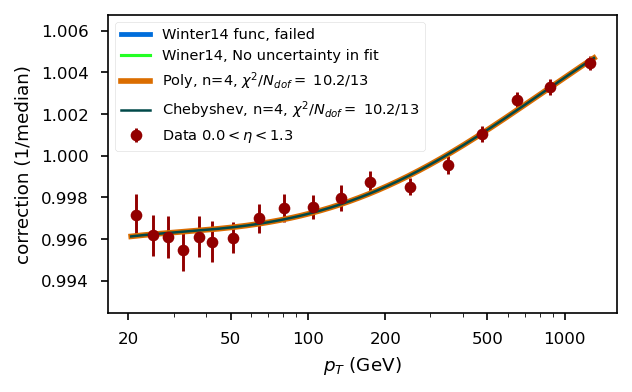

Fitting subsample:  c Eta bin = :  1
init_vals_Winter14 [0.982083, 0.238007, 4.35924, -0.0314618, 5.91028, 1.67749]
Winter 14 fit failed


/tmp/anpotreb/ipykernel_32231/164847569.py:11: RuntimeWarning: overflow encountered in exp
  + (p6*np.exp(-p7*((np.log10(x)-p8)*(np.log10(x)-p8))))


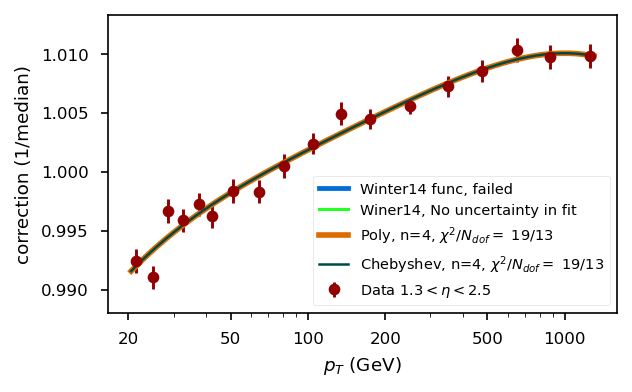

Fitting subsample:  c Eta bin = :  2
init_vals_Winter14 [0.733505, 7.26794, 12.2028, -0.756302, 0.0895257, -1.96324]
Two fits failed


/tmp/anpotreb/ipykernel_32231/164847569.py:4: RuntimeWarning: overflow encountered in exp
  return p0+(p1/((logx**2)+p2)) + (p3*np.exp(-p4*((logx-p5)*(logx-p5))))


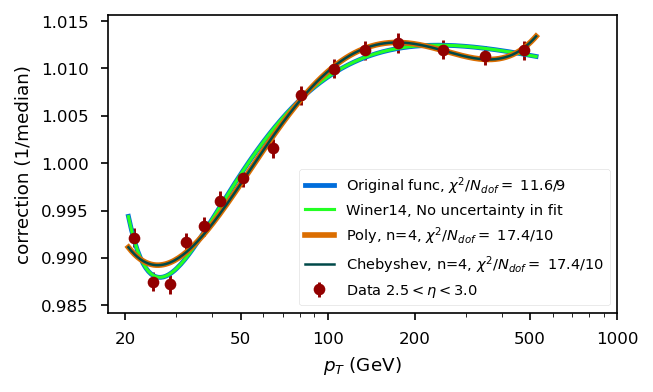

Fitting subsample:  c Eta bin = :  3
init_vals_Winter14 [0.932305, 1.15954, 17.1731, -0.471313, 2.58424, 0.254917]
Winter 14 fit failed


/tmp/anpotreb/ipykernel_32231/164847569.py:4: RuntimeWarning: overflow encountered in exp
  return p0+(p1/((logx**2)+p2)) + (p3*np.exp(-p4*((logx-p5)*(logx-p5))))
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4/Thu/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


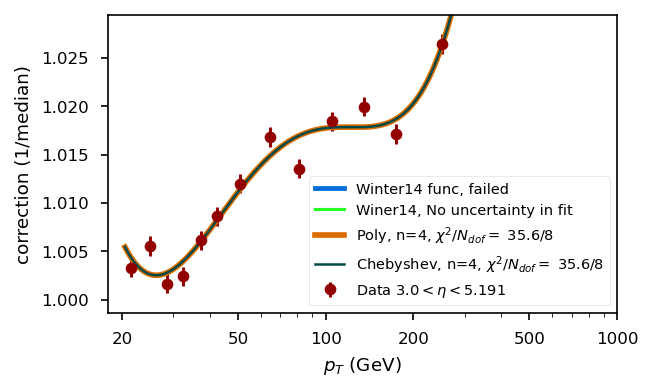

Fitting subsample:  u Eta bin = :  0
init_vals_Winter14 [1.28488, -46.3648, 151.749, -0.0108461, 15.4256, 1.63377]
Winter 14 fit failed
Two fits failed


/tmp/anpotreb/ipykernel_32231/164847569.py:11: RuntimeWarning: overflow encountered in exp
  + (p6*np.exp(-p7*((np.log10(x)-p8)*(np.log10(x)-p8))))
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4/Thu/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:488: RuntimeWarning: overflow encountered in multiply
  return transform * (func(xdata, *params) - ydata)


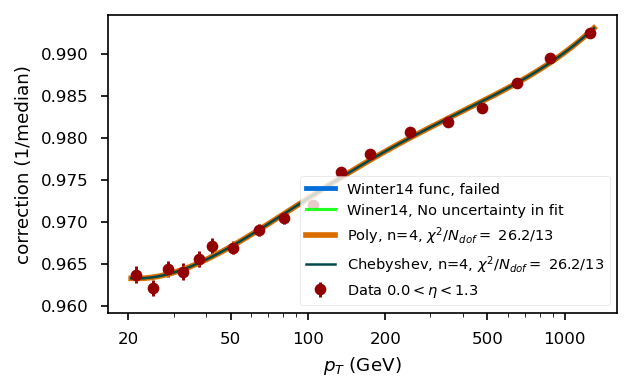

Fitting subsample:  u Eta bin = :  1
init_vals_Winter14 [1.50931, -118.71, 224.19, -0.0196468, 4.62655, 1.51581]
Winter 14 fit failed
Two fits failed


/tmp/anpotreb/ipykernel_32231/4121896105.py:3: RuntimeWarning: invalid value encountered in multiply
  mean = (1/read_data("Median", samp)[:,etabin])*closure[:,etabin]


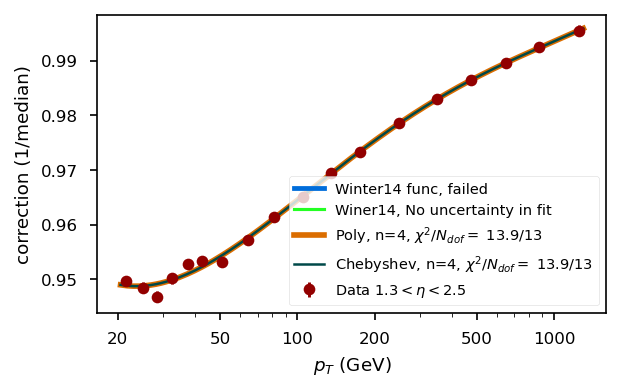

Fitting subsample:  u Eta bin = :  2
init_vals_Winter14 [0.692016, 8.26488, 11.1655, -0.802769, 0.116182, -1.16094]
Winter 14 fit failed
Two fits failed


/tmp/anpotreb/ipykernel_32231/4121896105.py:3: RuntimeWarning: invalid value encountered in multiply
  mean = (1/read_data("Median", samp)[:,etabin])*closure[:,etabin]


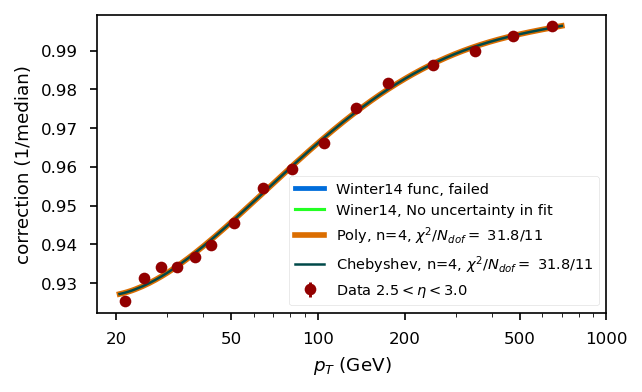

Fitting subsample:  u Eta bin = :  3
init_vals_Winter14 [1.01244, -0.0926519, -0.12138, -36949400.0, 7.15634, -0.625288]
Two fits failed


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4/Thu/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/tmp/anpotreb/ipykernel_32231/164847569.py:11: RuntimeWarning: overflow encountered in exp
  + (p6*np.exp(-p7*((np.log10(x)-p8)*(np.log10(x)-p8))))


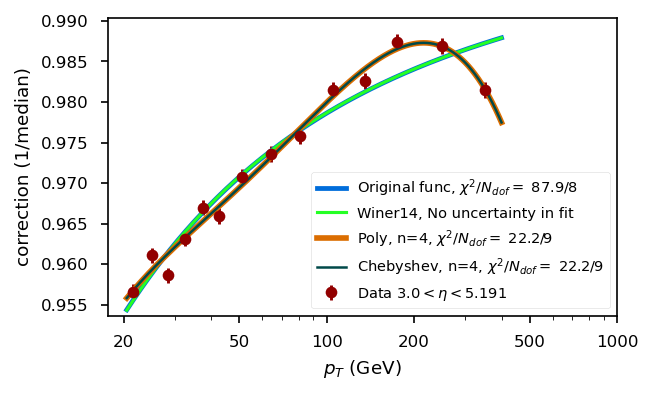

Fitting subsample:  d Eta bin = :  0
init_vals_Winter14 [1.28488, -46.3648, 151.749, -0.0108461, 15.4256, 1.63377]
Winter 14 fit failed


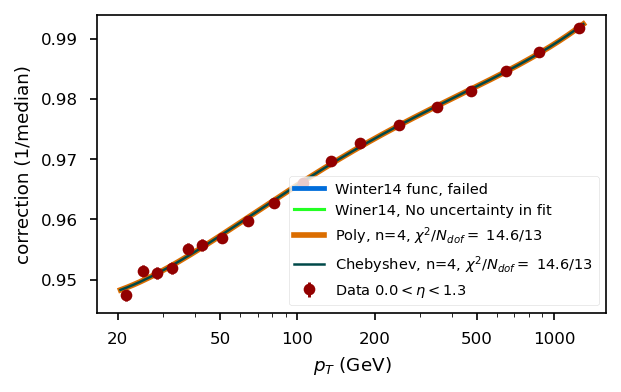

Fitting subsample:  d Eta bin = :  1
init_vals_Winter14 [1.50931, -118.71, 224.19, -0.0196468, 4.62655, 1.51581]
Winter 14 fit failed
Two fits failed


/tmp/anpotreb/ipykernel_32231/4121896105.py:3: RuntimeWarning: invalid value encountered in multiply
  mean = (1/read_data("Median", samp)[:,etabin])*closure[:,etabin]


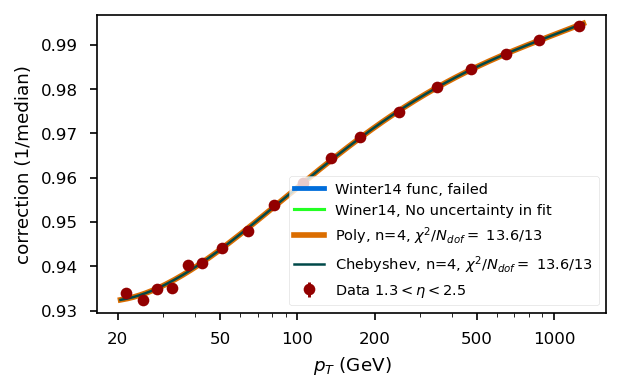

Fitting subsample:  d Eta bin = :  2
init_vals_Winter14 [0.692016, 8.26488, 11.1655, -0.802769, 0.116182, -1.16094]
Winter 14 fit failed
Two fits failed


/tmp/anpotreb/ipykernel_32231/4121896105.py:3: RuntimeWarning: invalid value encountered in multiply
  mean = (1/read_data("Median", samp)[:,etabin])*closure[:,etabin]


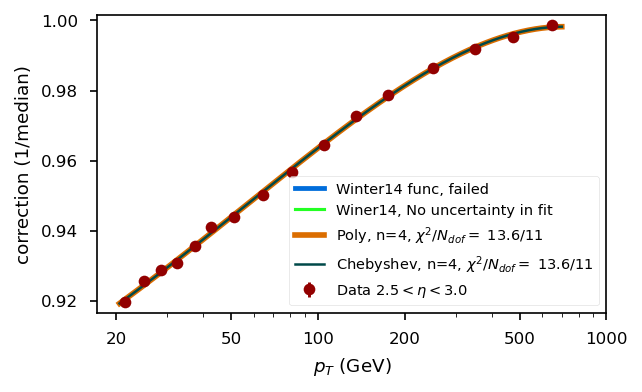

Fitting subsample:  d Eta bin = :  3
init_vals_Winter14 [1.01244, -0.0926519, -0.12138, -36949400.0, 7.15634, -0.625288]
Two fits failed


/tmp/anpotreb/ipykernel_32231/4121896105.py:3: RuntimeWarning: invalid value encountered in multiply
  mean = (1/read_data("Median", samp)[:,etabin])*closure[:,etabin]
/tmp/anpotreb/ipykernel_32231/164847569.py:4: RuntimeWarning: overflow encountered in exp
  return p0+(p1/((logx**2)+p2)) + (p3*np.exp(-p4*((logx-p5)*(logx-p5))))
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4/Thu/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


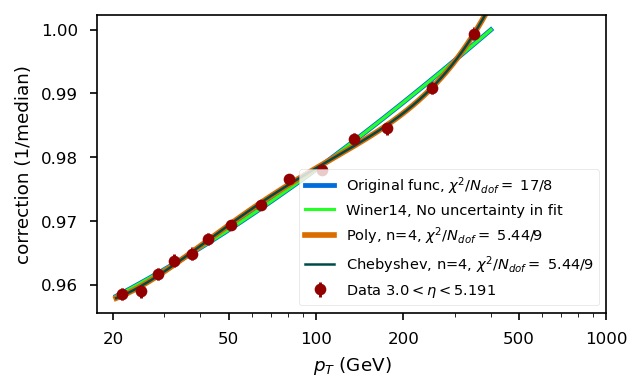

Fitting subsample:  g Eta bin = :  0
init_vals_Winter14 [0.877892, 3.10194, 1.16568, -677.876, 0.0325026, -12.9485]
Winter 14 fit failed
Two fits failed


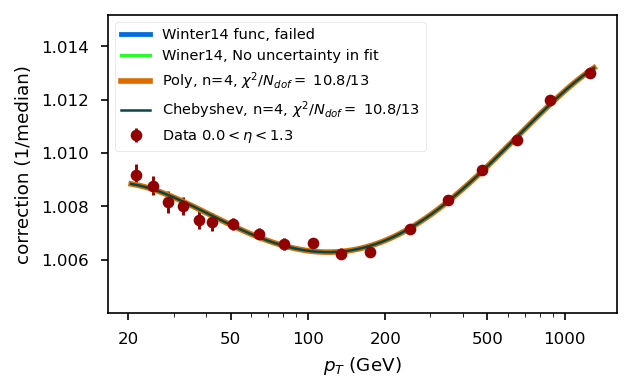

Fitting subsample:  g Eta bin = :  1
init_vals_Winter14 [0.983775, 0.247943, 1.55373, -0.0254802, 3.35748, 1.71263]
Two fits failed


/tmp/anpotreb/ipykernel_32231/4121896105.py:3: RuntimeWarning: invalid value encountered in multiply
  mean = (1/read_data("Median", samp)[:,etabin])*closure[:,etabin]


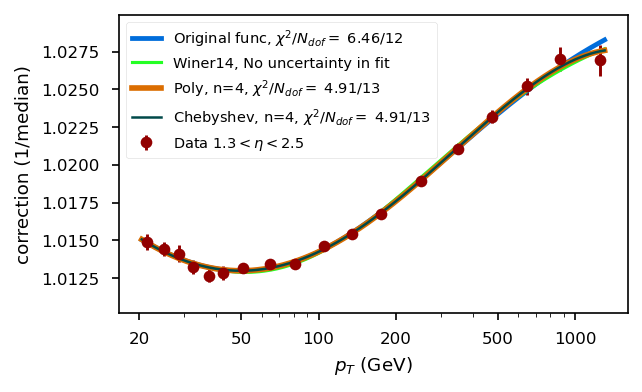

Fitting subsample:  g Eta bin = :  2
init_vals_Winter14 [-0.972548, 38.8683, 2.47151, -44.0233, 0.0901665, -3.15495]
Winter 14 fit failed
Two fits failed


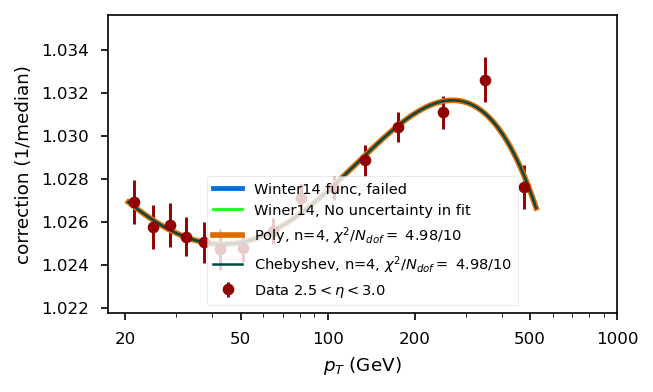

Fitting subsample:  g Eta bin = :  3
init_vals_Winter14 [1.0655, -0.0680325, -0.509038, -8594340.0, 42.6162, 0.357177]
Winter 14 fit failed


/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4/Thu/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


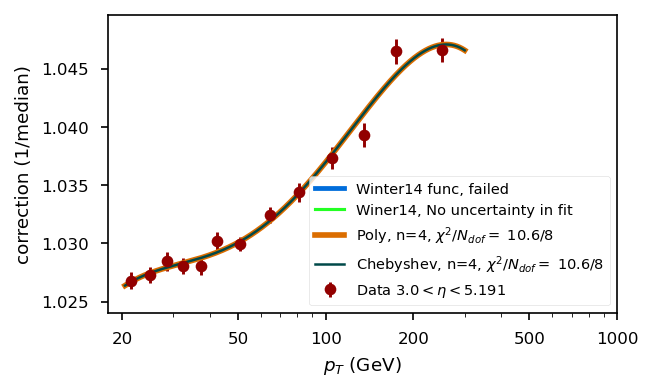

Fitting subsample:  s Eta bin = :  0
init_vals_Winter14 [1.28488, -46.3648, 151.749, -0.0108461, 15.4256, 1.63377]
Winter 14 fit failed
Two fits failed


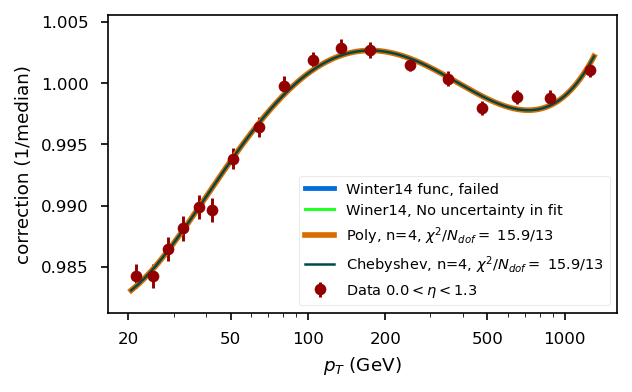

Fitting subsample:  s Eta bin = :  1
init_vals_Winter14 [1.50931, -118.71, 224.19, -0.0196468, 4.62655, 1.51581]
Winter 14 fit failed
Two fits failed


/tmp/anpotreb/ipykernel_32231/4121896105.py:3: RuntimeWarning: invalid value encountered in multiply
  mean = (1/read_data("Median", samp)[:,etabin])*closure[:,etabin]


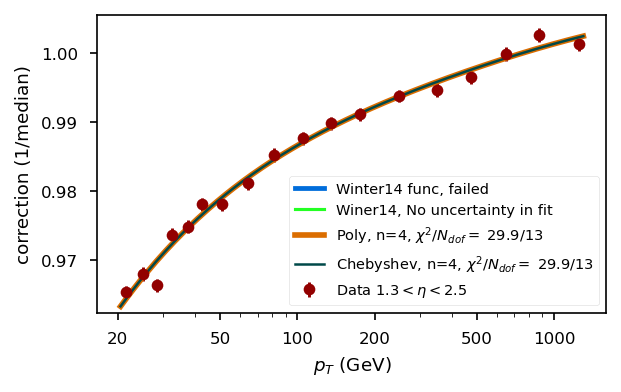

Fitting subsample:  s Eta bin = :  2
init_vals_Winter14 [0.692016, 8.26488, 11.1655, -0.802769, 0.116182, -1.16094]
Winter 14 fit failed
Two fits failed


/tmp/anpotreb/ipykernel_32231/4121896105.py:3: RuntimeWarning: invalid value encountered in multiply
  mean = (1/read_data("Median", samp)[:,etabin])*closure[:,etabin]
/tmp/anpotreb/ipykernel_32231/164847569.py:4: RuntimeWarning: overflow encountered in exp
  return p0+(p1/((logx**2)+p2)) + (p3*np.exp(-p4*((logx-p5)*(logx-p5))))


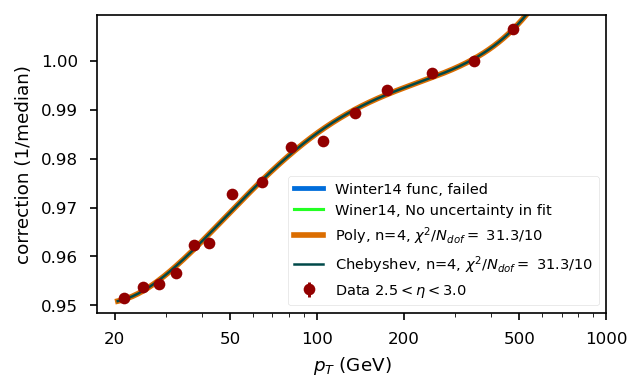

Fitting subsample:  s Eta bin = :  3
init_vals_Winter14 [1.01244, -0.0926519, -0.12138, -36949400.0, 7.15634, -0.625288]
Two fits failed


/tmp/anpotreb/ipykernel_32231/4121896105.py:3: RuntimeWarning: invalid value encountered in multiply
  mean = (1/read_data("Median", samp)[:,etabin])*closure[:,etabin]
/cvmfs/sft-nightlies.cern.ch/lcg/views/dev4/Thu/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/tmp/anpotreb/ipykernel_32231/164847569.py:11: RuntimeWarning: overflow encountered in exp
  + (p6*np.exp(-p7*((np.log10(x)-p8)*(np.log10(x)-p8))))


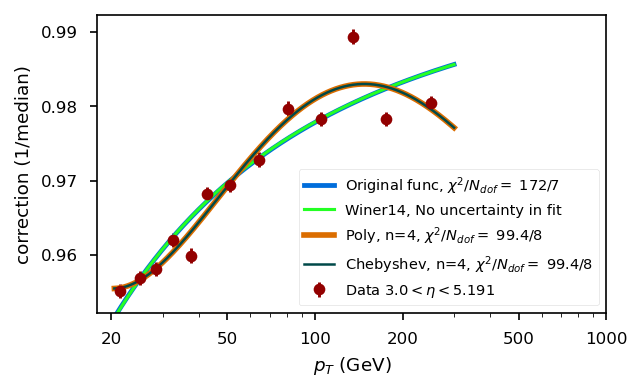

In [79]:
import sympy 
from sympy import chebyshevt
  
x = sympy.symbols('x')

subsamples = ['all', 'b', 'c', 'u', 'd', 'g', 's'] # ['_all','_b', '_c', '_u', '_d', '_g', '_s']
# subsamples = ['_b', '_c']
### Put the minimum limit on the relative uncertainty to min_rel_uncert
min_rel_uncert = 0.001
closure = read_data("Median", 'all')
# read_data("MedianStd", 'all')[:,etabin]**2
fit_res_all ={}
# etabins_all ={}
# nofpars_all ={}
for samp in subsamples:
    fit_res = []
    etabins_samp = []
    nofpars = []
    for etabin in range(4):
        init_vals_Winter14 = init_vals_2014[samp][etabin]
        fit_res_new = fit_corrections(samp, etabin, init_vals_Winter14, plot_initial_val=False)
        fit_res = np.concatenate([fit_res, fit_res_new])
        
        
    num = int(5 + fit_res[2])
    fit_res = np.reshape(fit_res,((len(fit_res)//num), num))
#     etabins_samp = np.reshape(etabins_samp,((len(etabins_samp)//2), 2))
    fit_res_all[my_mapping[samp]] = fit_res
#     etabins_all[my_mapping[samp]] = etabins_samp
#     nofpars_all[my_mapping[samp]] = nofpars
'a';

In [48]:
fit_res_all['aJ'][0]

array([ 0.00000000e+00,  1.30000000e+00,  5.00000000e+00,  2.00000000e+01,
        1.50000000e+03,  9.99999500e-01,  9.50991926e-07, -6.60047632e-07,
        1.98432948e-07, -2.18490753e-08])

In [49]:
# expr = 0
# for ii in range(len(p_cheb3)):
#     expr+=p_cheb3[ii]* chebyshevt(ii,x)
# poly_coefs = np.array(sympy.Poly(expr).all_coeffs(), dtype=float)

In [50]:
# fit_res_all

In [58]:
header_txt = ('# L5 flavor corrections for IC5 algorithm \n'+
'# [gJ] (gluons from diJet mixture) \n'+
'# [bJ] (b quark from diJet mixture) \n'+
'# [cJ] (c quark from diJet mixture) \n'+
'# [qJ] (uds quarks from diJet mixture) \n'+
'# [udJ] (ud quark from diJet mixture) \n'+
'# [uJ] (u quark from diJet mixture) \n'+
'# [dJ] (d quark from diJet mixture) \n'+
'# [gT] (gluons from ttbar events) \n'+
'# [qT] (uds quarks from ttbar events) \n'+
'# [cT] (c quark from ttbar events) \n'+
'# [bT] (b quark from ttbar events) \n'+
'# energy mapping: ptGen = (pt - p5)/p6 \n'+
'# parametrization: p2+p3*logPt+p4*logPt^2, constant if Pt<p0 or Pt>p1 \n'+
'#etamin  etamax  #ofparameters  ptmin  ptmax    p2         p3        p4     mapping: p5        p6 ')

In [59]:
# np.vstack([np.hstack([np.flip(fit_res_all['aJ'][:,0:2]*-1), np.flip(fit_res_all['aJ'][:,2:], 0)]), fit_res_all['aJ']])

In [60]:
with open("Summer20UL18_V2_MC/Summer20UL18_V2_MC_L5Flavor_AK4PFchs.txt", 'w') as file:
    file.write(header_txt+'\n')
    for key in fit_res_all.keys():
        file.write('['+key.replace("T","J")+']\n')
        file.write('{1 JetEta 1 JetPt ([0]+[1]*log10(x)+[2]*log10(x)*log10(x)+[3]*log10(x)*log10(x)*log10(x)+[4]*log10(x)*log10(x)*log10(x)*log10(x)) Correction L5Flavor}\n')
        fit_res = fit_res_all[key]
        ### copy from the positive eta region into the negative
        fit_res = np.vstack([np.hstack([np.flip(fit_res[:,0:2]*-1), np.flip(fit_res[:,2:], 0)]), fit_res])
        for row in fit_res:
            row[2] = row[2]+2  #+2 because of the pt lower/higher limits that are not accounted into the # parameters before
            line2write = ('{:>11} '*5+'{:>13} '*(int(row[2])-2)).format(*row[:2], int(row[2]), *np.round(row[3:], 7))+'\n'
            file.write(line2write);

4; ## to suppress printouts of write

### Fit median responses in a specific bin interactivelly

In [57]:
import sympy 
from sympy import chebyshevt
  
x = sympy.symbols('x')

# subsamples = ['','_b', '_c', '_u', '_d', '_g', '_s']
subsamples = ['_b', '_c']
### Put the minimum limit on the relative uncertainty to min_rel_uncert
min_rel_uncert = 0.001

etabin = 3
samp = '_b'

print('Fitting subsample: ', samp, 'Eta bin = : ', etabin)
mean = 1/read_data("Median", samp)[:,etabin]
meanvar = mean**2*read_data("MedianStd", samp)[:,etabin]**2

start = np.searchsorted(ptbins_c, 20, side='left')
mean_range = range(start-1, len(mean)-8)

means = mean[mean_range]
ptbins2fit = ptbins_c[mean_range]
validpt_mask = ~(np.isnan(means) | np.isinf(means) | (means==0))

means2fit = means[validpt_mask]
ptbins2fit = ptbins2fit[validpt_mask]
meanvar2fit = np.abs(meanvar[mean_range][validpt_mask])

### Put the minimum limit on the relative uncertainty to min_rel_uncert
meanstd = np.sqrt(meanvar2fit)
where_limit_std = meanstd>min_rel_uncert
meanstd[where_limit_std] = min_rel_uncert*means2fit[where_limit_std]

fit_min_lim = min(ptbins[:-1][mean_range][validpt_mask])
fit_max_lim = max(ptbins[1:][mean_range][validpt_mask])

xvals = np.linspace(ptbins2fit.min() - (1), ptbins2fit.max()+50,1000) #-200 to plot the fitted curved outside of the points
def sum_cheb(x, *p):
    return sum_cheb_tmp(x, ptbins2fit, *p)
def sum_cheb5(x, *p):
    return sum_cheb5_tmp(x, ptbins2fit, *p)    
def sum_cheb3(x, *p):
    return sum_cheb3_tmp(x, ptbins2fit, *p)  
def sum_cheb2(x, *p):
    return sum_cheb2_tmp(x, ptbins2fit, *p)  

try:
    p_resp, arr = curve_fit(response_fnc, ptbins2fit, means2fit, p0=init_vals_2014[samp[-1:]][etabin]) #0.793149, 4.60568, 11.1553, -0.123262, 0.878497, 1.52041
    p_resp_err, arr = curve_fit(response_fnc, ptbins2fit, means2fit, p0=p_resp, sigma=meanstd)
except(RuntimeError):
    print("Winter 14 fit failed")
    p_resp, p_resp_err = [[np.nan]*6]*2
#      = np.nan*6

try:
    p_resp2, arr = curve_fit(two_gaus_fnc, ptbins2fit, means2fit, p0=init_two_gaus) #0.793149, 4.60568, 11.1553, -0.123262, 0.878497, 1.52041
    p_resp_err2, arr = curve_fit(two_gaus_fnc, ptbins2fit, means2fit, p0=p_resp2, sigma=meanstd)
except(RuntimeError):
    print("Two fits failed")
    p_resp2, p_resp_err2 = [[np.nan]*9]*2
#      = np.nan*6


# p_resp_err
p_cheb1, arr = curve_fit(sum_cheb, ptbins2fit, means2fit, p0=[ 1, 1, 1, 1, 1])
p_cheb, arr = curve_fit(sum_cheb, ptbins2fit, means2fit, p0=p_cheb1, sigma=meanstd)
p_cheb5_1, arr = curve_fit(sum_cheb5, ptbins2fit, means2fit, p0=[ 1, 1, 1, 1, 1, 1])
p_cheb5, arr = curve_fit(sum_cheb5, ptbins2fit, means2fit, p0=p_cheb5_1, sigma=meanstd)
p_cheb3_1, arr = curve_fit(sum_cheb3, ptbins2fit, means2fit, p0=[ 1, 1, 1, 1])
p_cheb3, arr = curve_fit(sum_cheb3, ptbins2fit, means2fit, p0=p_cheb3_1, sigma=meanstd)
p_cheb2_1, arr = curve_fit(sum_cheb2, ptbins2fit, means2fit, p0=[ 1, 1, 1])
p_cheb2, arr = curve_fit(sum_cheb2, ptbins2fit, means2fit, p0=p_cheb2_1, sigma=meanstd)

expr = 0
for ii in range(len(p_cheb3)):
    expr+=p_cheb3[ii]* chebyshevt(ii,x)
poly_coefs = np.array(sympy.Poly(expr).all_coeffs(), dtype=float)
#         len(poly_coefs)

# fit_res = np.concatenate([fit_res,
#                           [etabins[etabin], etabins[etabin+1],
#                            len(p_cheb3), 
#                            fit_min_lim, fit_max_lim],
#                           p_cheb3 ])
nofpars.append(len(p_cheb3))

yvals_resp = response_fnc(xvals, *p_resp)
yvals_resp_err = response_fnc(xvals, *p_resp_err)
yvals = sum_cheb(xvals, *p_cheb)
#         yvals1 = sum_cheb(xvals, *p_cheb1)
yvalsC5 = sum_cheb5(xvals, *p_cheb5)
#         yvalsC5_1 = sum_cheb5(xvals, *p_cheb5_1)
yvalsC3 = sum_cheb3(xvals, *p_cheb3)
yvalsC2 = sum_cheb2(xvals, *p_cheb2)

chi2_resp = np.sum((response_fnc(ptbins2fit, *p_resp_err) - means2fit)**2/meanstd**2)
chi2_C4 = np.sum((sum_cheb(ptbins2fit, *p_cheb) - means2fit)**2/meanstd**2)
chi2_C5 = np.sum((sum_cheb5(ptbins2fit, *p_cheb5) - means2fit)**2/meanstd**2)
chi2_C3 = np.sum((sum_cheb3(ptbins2fit, *p_cheb3) - means2fit)**2/meanstd**2)
chi2_C2 = np.sum((sum_cheb2(ptbins2fit, *p_cheb2) - means2fit)**2/meanstd**2)
Ndof_C4 = len(ptbins2fit) - 5
Ndof_C5 = len(ptbins2fit) - 6
Ndof_C3 = len(ptbins2fit) - 4
Ndof_C2 = len(ptbins2fit) - 3
Ndof_resp = len(ptbins2fit) - 6


fig, ax = plt.subplots()

plt.errorbar(ptbins2fit, means2fit, yerr=meanstd, marker='o',
             linestyle="none", label=f'Data {etabins[etabin]}'+r'$<\eta<'+f'${etabins[etabin+1]}')

eta_string = '_eta'+str(etabins[etabin])+'to'+str(etabins[etabin+1])
eta_string = eta_string.replace('.','')
if np.isnan(chi2_resp): 
    winter14_lab = 'Winter14 func, failed'
else:
    winter14_lab= 'Original func, '+r'$\chi^2/N_{dof} = $'+r' {0:0.3g}/{1:0.0f}'.format(chi2_resp, Ndof_resp)

ax.plot(xvals, yvals_resp_err, label=winter14_lab, linewidth=1.8);
ax.plot(xvals, yvals_resp, label="Winer14, No uncertainty", linewidth=1.8);
ax.plot(xvals, yvals, label=r'Chebyshev, n=4, '+r'$\chi^2/N_{dof} = $'+r' {0:0.3g}/{1:0.0f}'.format(chi2_C4, Ndof_C4),linewidth=1.8);
#         ax.plot(xvals, yvalsC5, label=r'Chebyshev, n=5, '+r'$\chi^2/N_{dof} = $'+r' {0:0.3g}/{1:0.0f}'.format(chi2_C5, Ndof_C5),linewidth=1.8);
ax.plot(xvals, yvalsC3, label=r'Chebyshev, n=3, '+r'$\chi^2/N_{dof} = $'+r' {0:0.3g}/{1:0.0f}'.format(chi2_C3, Ndof_C3),linewidth=1.8);
ax.plot(xvals, yvalsC2, label=r'Chebyshev, n=2, '+r'$\chi^2/N_{dof} = $'+r' {0:0.3g}/{1:0.0f}'.format(chi2_C2, Ndof_C2),linewidth=1.8);

std = meanstd
norm_pos = (std<0.1) &  (std != np.inf)
#     print("(yerr_norm+y_norm)[norm_pos]) = ", (yerr_norm+y_norm)[norm_pos])
ax.set_ylim(np.min((means2fit-std)[norm_pos])-0.002 ,np.max((std+means2fit)[norm_pos])+0.002)

ax.set_xlabel(r'$p_T$ (GeV)');
ax.set_ylabel(r'mean response');
ax.set_xscale('log')

ax.set_xticks([])
ax.set_xticks([20, 50, 100, 200, 500, 1000])
ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

ax.legend(prop={'size': 7})

plt.show();
plt.close();
        
'a';

Fitting subsample:  _b Eta bin = :  3


FileNotFoundError: [Errno 2] No such file or directory: 'out_txt/EtaBinsvsPtBinsMedian__b_L5_QCD-JME.csv'

### Fit a specific $\eta$ $p_T$ bin

In [ ]:

mean = np.zeros((jetpt_length, jeteta_length))
median = np.zeros((jetpt_length, jeteta_length))
width = np.zeros((jetpt_length, jeteta_length))
chi2s = np.zeros((jetpt_length, jeteta_length))
meanvar = np.zeros((jetpt_length, jeteta_length))
#     idx = []

N_converge = 0
N_not_converge = 0

FitFigDir = 'fig/response_pt_eta'+samp+tag_full
print("Images will be saved under ", FitFigDir)
if not os.path.exists(FitFigDir):
    os.mkdir(FitFigDir)
    
edd = output['ptresponse'+samp].axis('ptresponse').edges()
plot_pt_edges = edd[0:np.nonzero(edd>=2.0)[0][0]]
# plot_pt_edges = output['ptresponse'+samp].axis('ptresponse').edges()[0:42] ##Put plotting limits to the histogram
hist_pt_edges = plot_pt_edges[1:-1]   #for plotting. To explude overflow from the plot
plot_response_axis = hist.Bin("jeteta", r"Jet $\eta$", hist_pt_edges)

xvals = output['ptresponse'+samp].axis('ptresponse').centers()[1:] #[1:] to exclude the second peak for low pt
f_xvals = np.linspace(0,5,5001)
response_edges = output['ptresponse'+samp].axis('ptresponse').edges()[1:]

In [ ]:
# np.where(xvals>=p[1]+np.abs(p[2])*1.5)

In [ ]:
samp=''

In [ ]:
etabins

In [ ]:
samp='_g'

In [ ]:
ptbins

In [ ]:
# histoMi = output['ptresponse'+samp].integrate('jeteta', hist.Interval(4.538,  4.716)).integrate('pt', hist.Interval(15, 40))
# histoPl = output['ptresponse'+samp].integrate('jeteta', hist.Interval(-4.716, -4.538)).integrate('pt', hist.Interval(15, 40))

histoMi = output['ptresponse'+samp].integrate('jeteta', hist.Interval(0,  1.3)).integrate('pt', hist.Interval(23, 27))
histoPl = output['ptresponse'+samp].integrate('jeteta', hist.Interval(-1.3, 0)).integrate('pt', hist.Interval(23, 27))
histo = (histoMi+histoPl)
yvals = histo.values()[('QCD',)][1:]  #[1:] to exclude the second peak for low pt

N = histo.integrate('ptresponse').values()[('QCD',)]-histo.values()[('QCD',)][0]

####################### Calculate median and rms ############################
yvals_cumsum = np.cumsum(yvals)
med_bin = np.nonzero(yvals_cumsum>N/2)[0][0] if N>0 else 0
median = response_edges[med_bin] + (N/2 - yvals_cumsum[med_bin-1])/yvals[med_bin]*(response_edges[med_bin+1]
                                                                          - response_edges[med_bin])

hist_mean = np.sum(xvals*yvals)/sum(yvals) 
hist_rms = np.sqrt(np.sum(yvals*((hist_mean-xvals)**2))/sum(yvals))
medianstd = 1.253 * hist_rms/np.sqrt(N)

####################### Fitting ############################
nonzero_bins = np.sum(yvals>0)
if nonzero_bins<2 or N<50:
    p2=[0,0,0]
    chi2 = np.nan
    arr = np.array([[np.nan]*3]*3)
    Ndof = 0
#                 print("Too little data points, skipping p = ", p2)
else:
    try:
        p, arr = curve_fit(gauss, xvals, yvals, p0=[10,1,1])
        N_converge += 1
             ######## Second Gaussian ########
        xfit_l = np.where(xvals>=p[1]-np.abs(p[2])*1.5)[0][0]
        xfit_hs = np.where(xvals>=p[1]+np.abs(p[2])*1.5)[0]
        xfit_h = xfit_hs[0] if len(xfit_hs)>0 else len(xvals)
#                     print("xfit_l = ", xfit_l, ", xfit_h = ", xfit_h)

        if len(range(xfit_l,xfit_h))<6: #if there are only 3pnts, the uncertainty is infty
            xfit_l = xfit_l-1
            xfit_h = xfit_h+1
            if len(range(xfit_l,xfit_h))<6:
                xfit_l = xfit_l-1
                xfit_h = xfit_h+1
        if xfit_l<0:
            xfit_h-=xfit_l
            xfit_l = 0
        xvals2 = xvals[xfit_l: xfit_h]
        yvals2 = yvals[xfit_l: xfit_h]
#                     if ptBin.lo>290:
#                         print("xfit_l = ", xfit_l, ", h = ", xfit_h)
#                         print("yvals = ", yvals)
#                         print("yvals2 = ", yvals2)
        p2, arr = curve_fit(gauss, xvals2, yvals2, p0=p)

        ygaus = gauss(xvals, *p2)
        chi2 = sum((yvals-ygaus)**2/(yvals+1E-9))
        Ndof = len(xvals2)-3
#                     if chi2<50000:
#                         pass
#                         print("Fit converged, p = ", p2, ", chi2 = ", chi2 )
#                     else:
#                         print("Fit failed because of high chi2, p = ", p2, ", chi2 = ", chi2 )
    except(RuntimeError):
        p2=[0,0,0]
#                     print("Fit failed because of non-convergance, p = ", p2)
        chi2 = np.nan
        arr = np.array([[np.nan]*3]*3)
        Ndof = 0
        N_not_converge += 1

fgaus2 = gauss(f_xvals, *p2)
histo = histo.rebin('ptresponse', plot_response_axis)
width_ik = np.abs(p2[2])




In [ ]:
fig, ax2 = plt.subplots();
hist.plot1d(histo, ax=ax2, overlay='dataset', overflow='all',
            fill_opts={'alpha': .5, 'edgecolor': (0,0,0,0.3), 'linewidth': 1.4})
# ax2.plot(f_xvals, fgaus, label='Gaus',linewidth=1.8)
ax2.plot(f_xvals, fgaus2, label='Gaus',linewidth=1.8)
ax2.set_xlabel("Response ($E_{RECO}/E_{GEN}$)")
ax2.set_xlim(plot_pt_edges[[0,-1]])
h = ax2.get_ylim()[1]/1.05
plt.text(0.03,0.95*h,r'Mean {0:0.3f}$\pm${1:0.3f}'.format(p2[1], np.sqrt(arr[1,1])))
plt.text(0.03,0.88*h,r'Width {0:0.3f}$\pm${1:0.3f}'.format(width_ik, np.sqrt(arr[2,2])))
plt.text(0.03,0.81*h,r'Median {0:0.3f}$\pm${1:0.3f}'.format(median, medianstd))
plt.text(0.03,0.73*h,r'$\chi^2/ndof$ {0:0.2g}/{1:0.0f}'.format(chi2, Ndof))
plt.text(0.03,0.66*h,r'N data = {0:0.3g}'.format(N))
ax2.legend();

# plt.close();    

In [ ]:
fig, ax2 = plt.subplots();
hist.plot1d(histo, ax=ax2, overlay='dataset', overflow='all',
            fill_opts={'alpha': .5, 'edgecolor': (0,0,0,0.3), 'linewidth': 1.4})
# ax2.plot(f_xvals, fgaus, label='Gaus',linewidth=1.8)
ax2.plot(f_xvals, fgaus2, label='Gaus',linewidth=1.8)
ax2.set_xlabel("Response ($E_{RECO}/E_{GEN}$)")
ax2.set_xlim(plot_pt_edges[[0,-1]])
h = ax2.get_ylim()[1]/1.05
plt.text(0.03,0.95*h,r'Mean {0:0.3f}$\pm${1:0.3f}'.format(p2[1], np.sqrt(arr[1,1])))
plt.text(0.03,0.88*h,r'Width {0:0.3f}$\pm${1:0.3f}'.format(width_ik, np.sqrt(arr[2,2])))
plt.text(0.03,0.81*h,r'Median {0:0.3f}$\pm${1:0.3f}'.format(median, medianstd))
plt.text(0.03,0.73*h,r'$\chi^2/ndof$ {0:0.2g}/{1:0.0f}'.format(chi2, Ndof))
plt.text(0.03,0.66*h,r'N data = {0:0.3g}'.format(N))
ax2.legend();

# plt.close();    

In [ ]:
print('-----'*10)
print("All done. Congrats!")